In [1]:
import tqdm
import numpy as np
import scipy.stats
import pandas as pd
import sklearn
import sklearn.cluster
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('ticks')
palette = sns.color_palette("RdBu_r", n_colors=25)

import ulsif

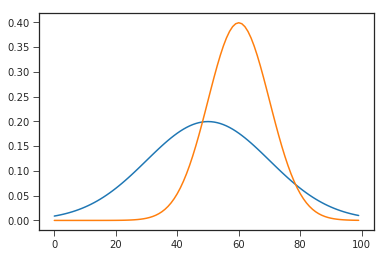

In [2]:
plt.plot([scipy.stats.norm(0, 2).pdf(x) for x in np.arange(-5, 5, 0.1)])
plt.plot([scipy.stats.norm(1, 1).pdf(x) for x in np.arange(-5, 5, 0.1)])

In [3]:
X_tr = scipy.stats.norm(0, 2).rvs(300)
X_te = scipy.stats.norm(1, 1).rvs(1000)

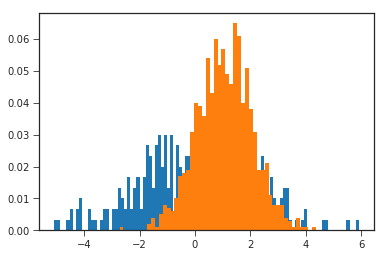

In [4]:
weights_tr = np.ones_like(X_tr)/len(X_tr)
weights_te = np.ones_like(X_te)/len(X_te)
plt.hist(X_tr, bins=100, weights=weights_tr)
plt.hist(X_te, bins=50, weights=weights_te)
plt.show()

In [5]:
cv = ulsif.DensityRatioCV()
cv.fit(X_tr.reshape(-1, 1), X_te.reshape(-1, 1))

sigma: 0.010000, lambda: 0.000001, score: 231308.501883
sigma: 0.010000, lambda: 0.000010, score: 28901.466838
sigma: 0.010000, lambda: 0.000100, score: 671.430785
sigma: 0.010000, lambda: 0.001000, score: 21.199967
sigma: 0.010000, lambda: 0.010000, score: 0.852677
sigma: 0.010000, lambda: 0.100000, score: -0.779331
sigma: 0.050000, lambda: 0.100000, score: -0.922257
sigma: 0.300000, lambda: 0.100000, score: -0.932084
sigma: 0.500000, lambda: 0.100000, score: -0.935313


In [6]:
cv.sigma_opt, cv.lambda_opt

(0.5, 0.1)

In [7]:
b = 100
sigma = cv.sigma_opt
lamb = cv.lambda_opt
means = sklearn.cluster.KMeans(b).fit(X_tr.reshape(-1, 1)).cluster_centers_[:, 0]

phi = np.array([scipy.stats.norm.pdf(X_tr, loc=mean, scale=sigma) for mean in means])
H = phi.dot(phi.transpose()) / len(X_tr)
h = np.mean([scipy.stats.norm.pdf(X_te, loc=mean, scale=sigma) for mean in means], axis=1)

alpha = np.linalg.solve(H + lamb * np.eye(b), h)
alpha[alpha < 0] = 0

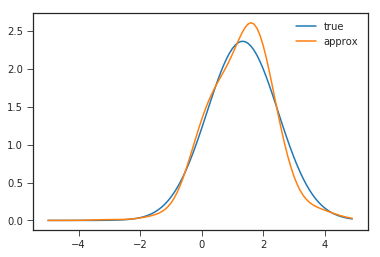

In [8]:
def true_ratio(x):
    return scipy.stats.norm(1, 1).pdf(x) / scipy.stats.norm(0, 2).pdf(x)

def approximated_ratio(x):
    return alpha.dot([scipy.stats.norm.pdf(x, mean, sigma) for mean in means])

plt.plot(np.arange(-5, 5, 0.1), [true_ratio(x) for x in np.arange(-5, 5, 0.1)], label='true')
plt.plot(np.arange(-5, 5, 0.1), [approximated_ratio(x) for x in np.arange(-5, 5, 0.1)], label='approx')
plt.legend()